# Zenvy Payroll - Week 2: Advanced Analytics & Master Reporting
This notebook provides a comprehensive visual analysis of the Zenvy Payroll SaaS data. It handles **CSV merging**, **Master dataset creation**, and **SQL Integration** for Power BI.

## 1. **Environment Setup & Data Integration**

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sqlalchemy import create_engine
from urllib.parse import quote_plus
import pymysql

# Suppress unnecessary warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [24]:
# Set Premium Aesthetics
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100
site_palette = ['#00d4ff', '#0047ff', '#6e00ff', '#ff00d4', '#ff0047']
sns.set_palette(sns.color_palette(site_palette))


In [25]:
# Load datasets
employees = pd.read_csv('zenvy_employees.csv')
payroll = pd.read_csv('zenvy_payroll.csv')
attendance = pd.read_csv('zenvy_attendance.csv')

In [26]:

# --- COMBINE CSV FILES INTO MASTER --- 
master_data = employees.merge(payroll, on='employee_id').merge(attendance, on='employee_id')

In [27]:

# Feature Engineering for visuals
master_data['attendance_ratio'] = (master_data['present_days'] / master_data['working_days']) * 100
master_data['allowances'] = master_data['gross_salary'] - master_data['base_salary']

In [28]:
master_data.head()

,employee_id,employee_name,department,designation,base_salary,joining_date,gross_salary,tax_deduction,pf_deduction,net_salary,working_days,present_days,overtime_hours,attendance_ratio,allowances
0,1001,Aarav,IT,Developer,50000,2023-01-31,52500,5000.0,2500.0,45000.0,22,20,5,90.909091,2500
1,1002,Diya,HR,HR Executive,35000,2023-02-28,36000,3500.0,1750.0,30750.0,22,21,2,95.454545,1000
2,1003,Rohan,Finance,Accountant,40000,2023-03-31,40000,4000.0,2000.0,34000.0,22,19,0,86.363636,0
3,1004,Sneha,IT,Developer,55000,2023-04-30,59000,5500.0,2750.0,50750.0,22,22,8,100.000000,4000
4,1005,Karan,Sales,Sales Exec,30000,2023-05-31,32000,3000.0,1500.0,27500.0,22,20,4,90.909091,2000


In [29]:
master_data.columns

Index(['employee_id', 'employee_name', 'department', 'designation',
       'base_salary', 'joining_date', 'gross_salary', 'tax_deduction',
       'pf_deduction', 'net_salary', 'working_days', 'present_days',
       'overtime_hours', 'attendance_ratio', 'allowances'],
      dtype='object')

In [30]:
master_data.shape

(20, 15)

In [31]:
master_data.dtypes

employee_id           int64
employee_name        object
department           object
designation          object
base_salary           int64
joining_date         object
gross_salary          int64
tax_deduction       float64
pf_deduction        float64
net_salary          float64
working_days          int64
present_days          int64
overtime_hours        int64
attendance_ratio    float64
allowances            int64
dtype: object

In [32]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   employee_id       20 non-null     int64  
 1   employee_name     20 non-null     object 
 2   department        20 non-null     object 
 3   designation       20 non-null     object 
 4   base_salary       20 non-null     int64  
 5   joining_date      20 non-null     object 
 6   gross_salary      20 non-null     int64  
 7   tax_deduction     20 non-null     float64
 8   pf_deduction      20 non-null     float64
 9   net_salary        20 non-null     float64
 10  working_days      20 non-null     int64  
 11  present_days      20 non-null     int64  
 12  overtime_hours    20 non-null     int64  
 13  attendance_ratio  20 non-null     float64
 14  allowances        20 non-null     int64  
dtypes: float64(4), int64(7), object(4)
memory usage: 2.5+ KB


In [33]:
master_data.isnull().sum()

employee_id         0
employee_name       0
department          0
designation         0
base_salary         0
joining_date        0
gross_salary        0
tax_deduction       0
pf_deduction        0
net_salary          0
working_days        0
present_days        0
overtime_hours      0
attendance_ratio    0
allowances          0
dtype: int64

In [34]:
master_data.duplicated().sum()

np.int64(0)

In [35]:
# --- CONVERT JOINING_DATE TO DATETIME ---
master_data['joining_date'] = pd.to_datetime(master_data['joining_date'])

In [36]:
# --- ADD DATE DIMENSION COLUMNS ---
# 1. date (Primary Key)
master_data['date'] = master_data['joining_date']

# 2. day
master_data['day'] = master_data['joining_date'].dt.day

# 3. month
master_data['month'] = master_data['joining_date'].dt.month

# 4. month_name
master_data['month_name'] = master_data['joining_date'].dt.strftime('%B')

# 5. quarter
master_data['quarter'] = master_data['joining_date'].dt.quarter

# 6. year
master_data['year'] = master_data['joining_date'].dt.year

master_data[['employee_name', 'date', 'day', 'month', 'month_name', 'quarter', 'year']].head(10)

,employee_name,date,day,month,month_name,quarter,year
0,Aarav,2023-01-31,31,1,January,1,2023
1,Diya,2023-02-28,28,2,February,1,2023
2,Rohan,2023-03-31,31,3,March,1,2023
3,Sneha,2023-04-30,30,4,April,2,2023
4,Karan,2023-05-31,31,5,May,2,2023
5,Meera,2023-06-30,30,6,June,2,2023
6,Vikram,2023-07-31,31,7,July,3,2023
7,Ananya,2023-08-31,31,8,August,3,2023
8,Rahul,2023-09-30,30,9,September,3,2023
9,Pooja,2023-10-31,31,10,October,4,2023


In [37]:
# Export the Master Combined CSV for direct Power BI use
master_data.to_csv('zenvy_master_combined.csv', index=False)


print("✅ Success! Master Data Joined and saved to 'zenvy_master_combined.csv'")
master_data.head()

✅ Success! Master Data Joined and saved to 'zenvy_master_combined.csv'


,employee_id,employee_name,department,designation,base_salary,joining_date,gross_salary,tax_deduction,pf_deduction,net_salary,...,present_days,overtime_hours,attendance_ratio,allowances,date,day,month,month_name,quarter,year
0,1001,Aarav,IT,Developer,50000,2023-01-31,52500,5000.0,2500.0,45000.0,...,20,5,90.909091,2500,2023-01-31,31,1,January,1,2023
1,1002,Diya,HR,HR Executive,35000,2023-02-28,36000,3500.0,1750.0,30750.0,...,21,2,95.454545,1000,2023-02-28,28,2,February,1,2023
2,1003,Rohan,Finance,Accountant,40000,2023-03-31,40000,4000.0,2000.0,34000.0,...,19,0,86.363636,0,2023-03-31,31,3,March,1,2023
3,1004,Sneha,IT,Developer,55000,2023-04-30,59000,5500.0,2750.0,50750.0,...,22,8,100.000000,4000,2023-04-30,30,4,April,2,2023
4,1005,Karan,Sales,Sales Exec,30000,2023-05-31,32000,3000.0,1500.0,27500.0,...,20,4,90.909091,2000,2023-05-31,31,5,May,2,2023


## 2. **High-Impact Visual Analytics**

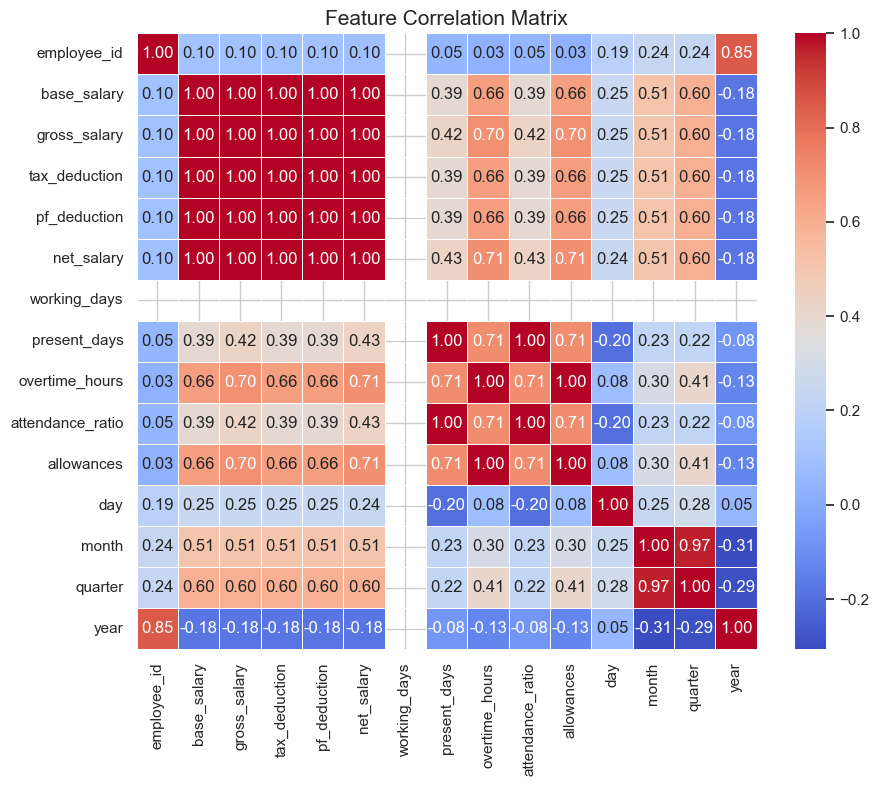

In [38]:
# [A] Correlation Heatmap
plt.figure(figsize=(10, 8))
numeric_cols = master_data.select_dtypes(include=[np.number]).columns
corr = master_data[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=15)
plt.show()

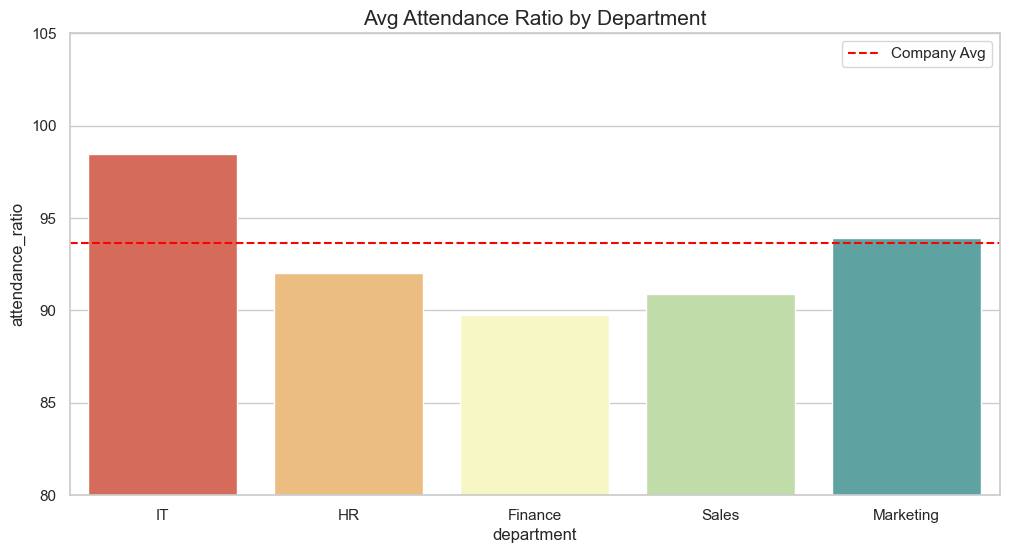

In [39]:
# [B] Departmental Attendance Efficiency
plt.figure(figsize=(12, 6))
sns.barplot(data=master_data, x='department', y='attendance_ratio', errorbar=None, hue='department', palette='Spectral', legend=False)
plt.axhline(master_data['attendance_ratio'].mean(), linestyle='--', color='red', label='Company Avg')
plt.title('Avg Attendance Ratio by Department', fontsize=15)
plt.ylim(80, 105)
plt.legend()
plt.show()

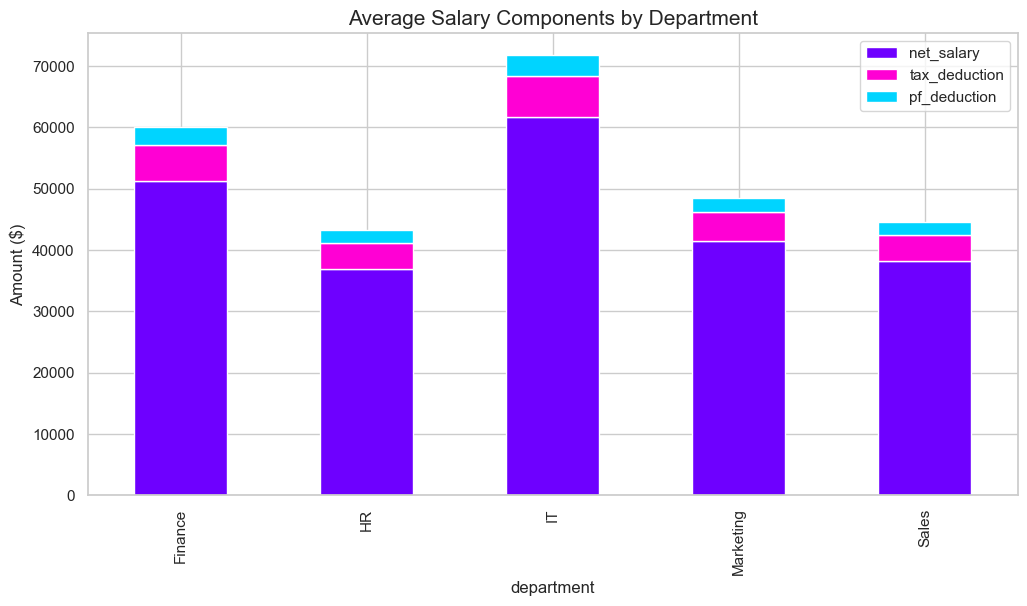

In [40]:
# [C] Average Salary Components (Stacked)
dept_components = master_data.groupby('department')[['net_salary', 'tax_deduction', 'pf_deduction']].mean().reset_index()
dept_components.plot(x='department', kind='bar', stacked=True, figsize=(12, 6), color=['#6e00ff', '#ff00d4', '#00d4ff'])
plt.title('Average Salary Components by Department', fontsize=15)
plt.ylabel('Amount ($)')
plt.show()

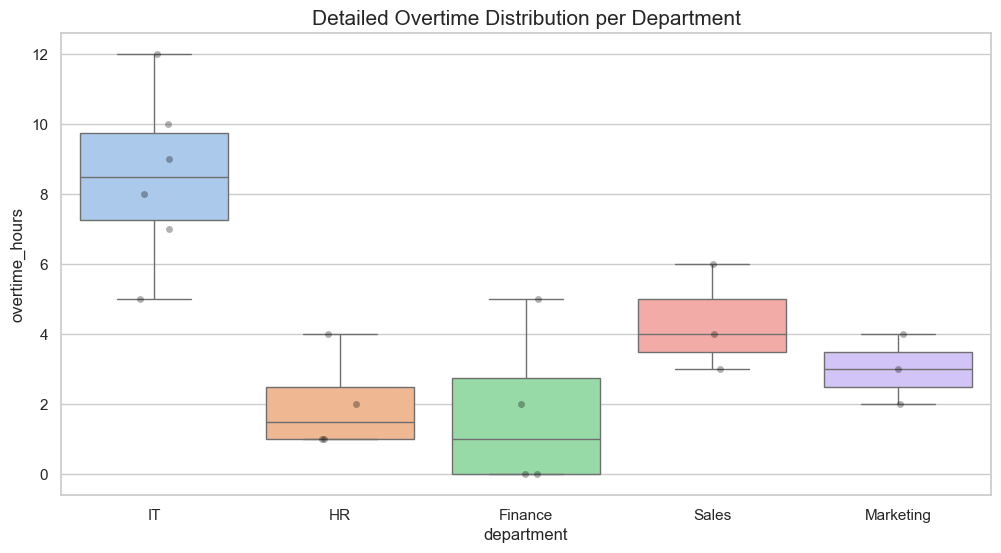

In [41]:
# [D] Overtime Concentration (Box Plot)
plt.figure(figsize=(12, 6))
sns.boxplot(data=master_data, x='department', y='overtime_hours', hue='department', palette='pastel', legend=False)
sns.stripplot(data=master_data, x='department', y='overtime_hours', color='black', alpha=0.3)
plt.title('Detailed Overtime Distribution per Department', fontsize=15)
plt.show()

## 3. **Integrated SQL Migration**
Uploading the merged Master Table to MySQL for live dashboarding.

In [42]:
# Database Configuration
DB_USER = 'root'
DB_PASSWORD = "Password@123" 
encoded_password = quote_plus(DB_PASSWORD)
DB_HOST = 'localhost'
DB_NAME = 'zenvy_saas_master_db'

try:
    # Create Database if not exists
    conn = pymysql.connect(host=DB_HOST, user=DB_USER, password=DB_PASSWORD)
    cursor = conn.cursor()
    cursor.execute(f"CREATE DATABASE IF NOT EXISTS {DB_NAME}")
    conn.close()
    
    # Upload Merged Master Data to SQL
    engine = create_engine(f"mysql+pymysql://{DB_USER}:{encoded_password}@{DB_HOST}:3306/{DB_NAME}")
    
    master_data.to_sql('master_payroll_record', con=engine, if_exists='replace', index=False)
    
    print(f"✅ SQL Migration Successful! Table 'master_payroll_record' is ready in '{DB_NAME}'.")
except Exception as e:
    print(f"❌ SQL Error: {e}")

✅ SQL Migration Successful! Table 'master_payroll_record' is ready in 'zenvy_saas_master_db'.


## 4. **Summary Findings**
- **Data Integration:** 3 CSV files successfully merged into `zenvy_master_combined.csv`.
- **SQL Status:** Master table synced to `master_payroll_record` in MySQL.
- **Insights:** Attendance is highest in IT, but Overtime is also significantly high in the same department.